In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

Using TensorFlow backend.


In [2]:
#Check Versions
print(tf.__version__) #1.15.0
print(keras.__version__) #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

We will now parametrize our network by giving it a $\mu$ value in addition to $X_i\sim\mathcal{N}(\mu, 1)$.

First we uniformly sample $\mu$ values in some range

In [3]:
n_data_points = 10**6
mu_min = -2
mu_max = 2
mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

We then sample from normal distributions with this $\mu$ value

In [4]:
X0 = [(np.random.normal(0, 1), mu) for mu in mu_values] # Note the zero in normal(0, 1) 
X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values]

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. 

Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

In [5]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Build Model

In [6]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

## Train DCTR model

In [7]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=200, 
          batch_size = 10000,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1600000 samples, validate on 400000 samples
Epoch 1/200





1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5765 - val_loss: 0.5656
Epoch 2/200
1600000/1600000 [==============================] - 2s 1us/step - loss: 0.5635 - val_loss: 0.5646
Epoch 3/200
1600000/1600000 [==============================] - 2s 1us/step - loss: 0.5630 - val_loss: 0.5643
Epoch 4/200
1600000/1600000 [==============================] - 2s 1us/step - loss: 0.5630 - val_loss: 0.5643
Epoch 5/200
1600000/1600000 [==============================] - 2s 1us/step - loss: 0.5628 - val_loss: 0.5641
Epoch 6/200
1600000/1600000 [==============================] - 2s 1us/step - loss: 0.5629 - val_loss: 0.5644
Epoch 7/200
1600000/1600000 [==============================] - 2s 1us/step - loss: 0.5628 - val_loss: 0.5641
Epoch 8/200
1600000/1600000 [==============================] - 2s 1us/step - loss:

# Saving Model

In [8]:
'''
model_json = dctr_model.to_json()
with open("1d_gaussian_dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dctr_model.save_weights("1d_gaussian_dctr_model.h5")
print("Saved model to disk")
'''

'\nmodel_json = dctr_model.to_json()\nwith open("1d_gaussian_dctr_model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\ndctr_model.save_weights("1d_gaussian_dctr_model.h5")\nprint("Saved model to disk")\n'

# Alternative Fit

# Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

In [9]:
N = 10**6
theta0_param = 0 #this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1. #this is the data (the target)

theta0 = np.random.normal(theta0_param,1,N)
theta1 = np.random.normal(theta1_param,1,N)
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0,theta1])
yvals = np.concatenate([labels0,labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals, yvals, test_size=0.5)

# Fitting Model

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

# Loading Model

In [10]:
# load json and create model
'''
json_file = open('1d_gaussian_dctr_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dctr_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
dctr_model.load_weights("1d_gaussian_dctr_model.h5")
print("Loaded model from disk")
'''


'\njson_file = open(\'1d_gaussian_dctr_model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\ndctr_model = keras.models.model_from_json(loaded_model_json)\n# load weights into new model\ndctr_model.load_weights("1d_gaussian_dctr_model.h5")\nprint("Loaded model from disk")\n'

# Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [11]:
def reweight(d): #from NN (DCTR)
    f = dctr_model(d)
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

def analytical_reweight(d): #from analytical formula for normal distributions
    events = d[:,0]
    param = d[:,1]
    weights = K.exp(-(0.5*(events-param)**2)+(0.5*(events-0.0)**2))
    weights = K.expand_dims(weights, axis = 1)
    return weights

In [12]:
# Change to True for analytical_reweight

reweight_analytically = True

# Creating Model

In [13]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()


def my_loss_wrapper(inputs,val=0.):
    x  = inputs
    x = K.gather(x, np.arange(500))

    theta = 0. #starting value
    theta_prime = val
    
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape = x.shape)*theta_prime
    #combining and reshaping into correct format:
    data = K.concatenate((x, concat_input_and_params), axis=-1)
    
    if reweight_analytically == False: #NN reweight
        w = reweight(data)
    else: # analytical reweight
        w = analytical_reweight(data)
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


# Training Model

In [14]:
thetas = np.linspace(-2,2,41)
lvals = []


for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, epochs=1, batch_size=500,validation_data=(np.array(X_test), y_test),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
print(lvals)

testing theta = : -2.0
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.0505 - acc: 0.6220 - val_loss: 0.0494 - val_acc: 0.6253
testing theta = : -1.9
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.0542 - acc: 0.6266 - val_loss: 0.0541 - val_acc: 0.6273
testing theta = : -1.8
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.0593 - acc: 0.6322 - val_loss: 0.0593 - val_acc: 0.6294
testing theta = : -1.7
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.0648 - acc: 0.6367 - val_loss: 0.0648 - val_acc: 0.6367
testing theta = : -1.6
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] 

1000000/1000000 [==============================] - 12s 12us/step - loss: 0.2295 - acc: 0.3563 - val_loss: 0.2292 - val_acc: 0.3553
testing theta = : 1.7000000000000002
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 13s 13us/step - loss: 0.2227 - acc: 0.3620 - val_loss: 0.2225 - val_acc: 0.3647
testing theta = : 1.8000000000000003
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 13s 13us/step - loss: 0.2154 - acc: 0.3671 - val_loss: 0.2151 - val_acc: 0.3670
testing theta = : 1.9000000000000004
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 13s 13us/step - loss: 0.2075 - acc: 0.3734 - val_loss: 0.2072 - val_acc: 0.3742
testing theta = : 2.0
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 13s 13us/step - loss: 0.1993 - acc: 

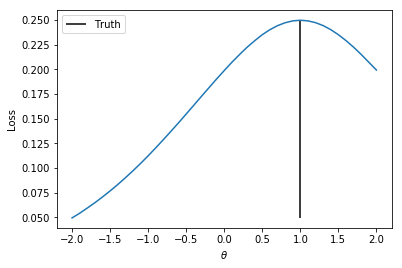

In [15]:
plt.plot(thetas,lvals)
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(np.mean(theta1), ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.legend()
plt.show()

We've shown for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

# Building and Training Fitting Model

In [16]:
print_weights = LambdaCallback(on_epoch_end=lambda batch,
                               logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

In [17]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape = list(),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False

batch_size = 1000
lr = 1e-5 #smaller learning rate yields better precision
epochs = 100 #but requires more epochs to train
optimizer = keras.optimizers.Adam(lr=lr)

def my_loss_wrapper_fit(inputs,mysign = 1):
    x  = inputs
    x = K.gather(x, np.arange(batch_size))
    theta = 0. #starting value
    #Getting theta_prime:
    if train_theta == False:
        theta_prime = model_fit.layers[-1].get_weights() #when not training theta, fetch as np array 
    else:
        theta_prime = model_fit.trainable_weights[-1] #when trainingn theta, fetch as tf.Variable
        
    #creating tensor with same length as inputs, with theta_prime in every entry
    theta0_stack = K.ones_like(x,dtype=tf.float32)*theta0 
    concat_input_and_params = K.ones(shape = (x.shape), dtype=tf.float32)*theta_prime
    
    #combining and reshaping into correct format:
    data = K.concatenate((x, concat_input_and_params), axis=-1)
   
    if reweight_analytically == False: #NN reweight
        w = reweight(data)
    else: # analytical reweight
        w = analytical_reweight(data)
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = mysign*(y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss
    
for k in range(epochs):    
    print("Epoch: ",k )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)    
    pass
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 1         
Total params: 16,898
Trainable params: 16,898
Non-trainable params: 0
_________________________________________________________________
Epoch:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 9s

1000000/1000000 [==============================] - 12s 12us/step - loss: 0.2222 - acc: 0.6897 - val_loss: 0.2219 - val_acc: 0.6899
. theta fit =  0.29499024
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 10s 10us/step - loss: -0.2231 - acc: 0.6893 - val_loss: -0.2233 - val_acc: 0.6899
. theta fit =  0.31473437
Epoch:  16
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2236 - acc: 0.6891 - val_loss: 0.2233 - val_acc: 0.6896
. theta fit =  0.31473437
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 10s 10us/step - loss: -0.2244 - acc: 0.6890 - val_loss: -0.2246 - val_acc: 0.6896
. theta fit =  0.3344934
Epoch:  17
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [======================

1000000/1000000 [==============================] - 15s 15us/step - loss: 0.2416 - acc: 0.6823 - val_loss: 0.2412 - val_acc: 0.6832
. theta fit =  0.6262587
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 14s 14us/step - loss: -0.2421 - acc: 0.6823 - val_loss: -0.2421 - val_acc: 0.6832
. theta fit =  0.64523184
Epoch:  33
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 15s 15us/step - loss: 0.2424 - acc: 0.6812 - val_loss: 0.2421 - val_acc: 0.6812
. theta fit =  0.64523184
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 14s 14us/step - loss: -0.2429 - acc: 0.6803 - val_loss: -0.2428 - val_acc: 0.6812
. theta fit =  0.6643696
Epoch:  34
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [=======================

1000000/1000000 [==============================] - 18s 18us/step - loss: 0.2496 - acc: 0.6658 - val_loss: 0.2493 - val_acc: 0.6740
. theta fit =  0.91794795
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 17s 17us/step - loss: -0.2497 - acc: 0.6733 - val_loss: -0.2494 - val_acc: 0.6740
. theta fit =  0.9310839
Epoch:  50
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 18s 18us/step - loss: 0.2497 - acc: 0.6621 - val_loss: 0.2494 - val_acc: 0.6715
. theta fit =  0.9310839
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 17s 17us/step - loss: -0.2498 - acc: 0.6707 - val_loss: -0.2495 - val_acc: 0.6715
. theta fit =  0.9422963
Epoch:  51
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [========================

1000000/1000000 [==============================] - 21s 21us/step - loss: 0.2500 - acc: 0.5319 - val_loss: 0.2497 - val_acc: 0.4917
. theta fit =  0.99899745
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 20s 20us/step - loss: -0.2500 - acc: 0.4925 - val_loss: -0.2497 - val_acc: 0.4917
. theta fit =  0.99918026
Epoch:  67
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 20s 20us/step - loss: 0.2500 - acc: 0.5073 - val_loss: 0.2497 - val_acc: 0.5647
. theta fit =  0.99918026
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 19s 19us/step - loss: -0.2500 - acc: 0.5661 - val_loss: -0.2497 - val_acc: 0.5647
. theta fit =  0.9998846
Epoch:  68
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [======================

1000000/1000000 [==============================] - 24s 24us/step - loss: 0.2500 - acc: 0.5188 - val_loss: 0.2497 - val_acc: 0.5848
. theta fit =  0.9987766
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 23s 23us/step - loss: -0.2500 - acc: 0.5853 - val_loss: -0.2497 - val_acc: 0.5848
. theta fit =  1.0002344
Epoch:  84
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 24s 24us/step - loss: 0.2500 - acc: 0.5206 - val_loss: 0.2497 - val_acc: 0.6179
. theta fit =  1.0002344
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 23s 23us/step - loss: -0.2500 - acc: 0.6178 - val_loss: -0.2497 - val_acc: 0.6179
. theta fit =  1.0004667
Epoch:  85
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [=========================

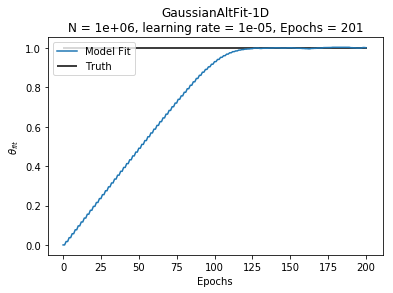

In [18]:

plt.plot(fit_vals, label='Model Fit')
plt.hlines(np.mean(theta1), 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("GaussianAltFit-1D\nN = {:.0e}, learning rate = {:.0e}, Epochs = {:.0f}".format(N, lr, len(fit_vals)))
#plt.savefig("GaussianAltFit-1D-eg4: N = {:.0e}, learning rate = {:.0e}, Epochs = {:.0f}.png".format(N, lr, len(fit_vals)))
plt.show()
